# The Analysis and Prediction of Credit Card Customer Churn


# Import Libraries

In [1]:
#Import libraries
import numpy as np
import pandas as pd #for indexing our data
import seaborn as sns
%matplotlib inline 
# import mylib #for adjusting violin plot size
from matplotlib import pyplot as plt #for visualizing our data
from matplotlib import style
from scipy.stats import chi2_contingency #for doing chi-square analysis
from sklearn.preprocessing import StandardScaler #for feature scaling
from sklearn.linear_model import LogisticRegression #for performing logistic regression model
from sklearn.neighbors import KNeighborsClassifier #for performing a KNN model
from sklearn.ensemble import RandomForestClassifier #for performing a random forest classifier model
from sklearn.naive_bayes import GaussianNB #for performing a Gaussian Naive Bayes classifier model 
from sklearn.tree import DecisionTreeClassifier #for performing a Decision Trees classifier mod
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict #for splitting the datasets into train and test, and to get k-fold cross validation and cross validation of a model
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, classification_report, f1_score #metrics for evaluating models
from statsmodels.stats.outliers_influence import variance_inflation_factor #detecting/measuring multicollinearity


# Read and Rename Data Columns

In [2]:
# Read csv file, dameframe named as "bank"
# Rename column names for better understanding
# 'CLIENTNUM' (later renamed 'Client_Num') is a unique identifier for the customer that holds the account (i.e. won't affect whether a customer attrited)
# Drop last two columns since they are not helpful in determining whether a customer attrited
# Define "Unknown" category within education level, marital status, and income category as missing values 
bank=pd.read_csv(
                  #"/gdrive/MyDrive/Data Science 1 - Group 23/BankChurners.csv" 
                 'BankChurners.csv'
                 ,header=0
                 ,names=["Client_Num","Attrition_Flag","Customer_Age","Gender","Dependent_Count","Education_Level"
                         ,"Marital_Status","Income_Category"
                         ,"Card_Category"
                         ,"Months_on_Book","Product_Count","Months_Inactive_12month","Contacts_Count_12month"
                         ,"CreditCard_Limit","CreditCard_Revolving_Balance"
                         ,"CreditLine_Avg_12month"
                         ,"Amt_Chng_Q4_Q1","Total_Trans_Amt_12month","Total_Trans_Count_12month","Count_Chng_Q4_Q1"
                         ,"Avg_Utilization_Ratio"]
                 ,index_col=["Client_Num"]
                 ,usecols= [*range(0,21)] 
                 ,na_values='Unknown')
bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 768805383 to 714337233
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Attrition_Flag                10127 non-null  object 
 1   Customer_Age                  10127 non-null  int64  
 2   Gender                        10127 non-null  object 
 3   Dependent_Count               10127 non-null  int64  
 4   Education_Level               8608 non-null   object 
 5   Marital_Status                9378 non-null   object 
 6   Income_Category               9015 non-null   object 
 7   Card_Category                 10127 non-null  object 
 8   Months_on_Book                10127 non-null  int64  
 9   Product_Count                 10127 non-null  int64  
 10  Months_Inactive_12month       10127 non-null  int64  
 11  Contacts_Count_12month        10127 non-null  int64  
 12  CreditCard_Limit              10127 non-null  fl

The 'bank' dataset contains information for 10,127 customers. There are six categorical attributes ('Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category') and 14 numerical attributes. 

The most frequent category for each of the attributes:
Attrition_Flag = Existing Customer, 
Gender = female,
Education_Level = Graduate,
Marital_Status = Married,
Income_Category = Less than $40K, and
Card_Category = Blue.

The attributes, 'Education_Level', 'Marital_Status', and 'Income_Category' all have customers with missing values (i.e. previsouly categorized as "Unknown"). The missing values account for roughly 15%, 7%, and 11% of the customers within the 'Education_Level', 'Marital_Status', and 'Income_Category' attributes, respectively.

# Data Cleaning
 

## Drop redundant attributes

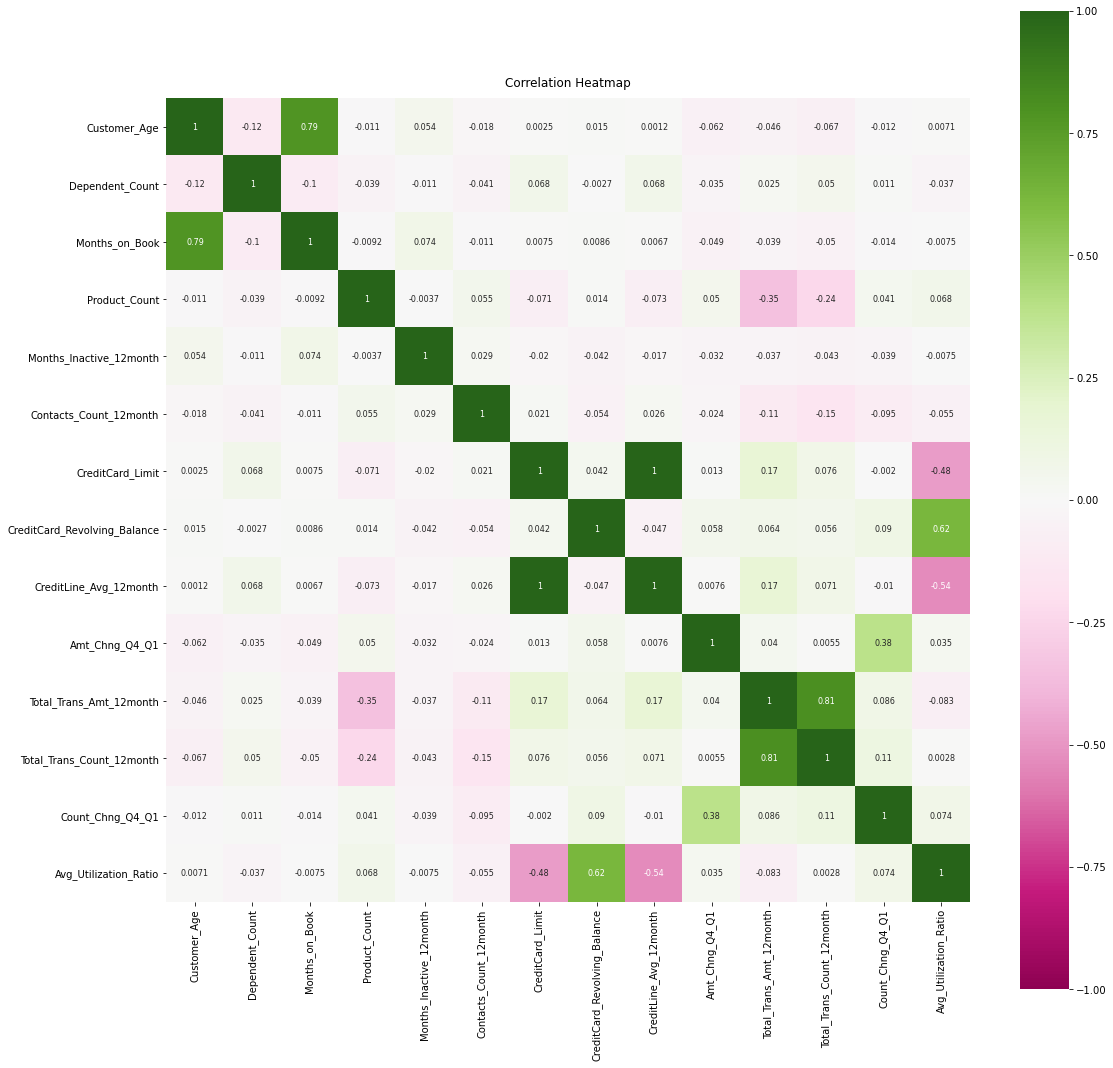

In [3]:
#correlation heatmap
plt.figure(figsize=(18,18))

heatmap = sns.heatmap(bank.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

There is a strong correlation between 'CreditCard_Limit' and 'CreditLine_Avg_12month' (r=1.0), between 'Total_Trans_Amt_12month' and 'Total_Trans_Count_12month' (r=0.81), and between 'Customer_Age' and 'Months_on_Book' (r=0.79). There is a medium correlation between 'Avg_Utilization_Ratio' and the following three sttributes, 'CrediCard_Revolving_Balance' (r=0.62), 'CreditLine_Avg_12month' (r=0.54), and 'CreditCard_Limit' (r=0.48). There is also a medium correlation between 'Amt_Chng_Q4_Q1' and 'Count_Chng_Q4_Q1' (r=0.38) and between 'Product_Count' and 'Total_Trans_Amt_12month' (r=0.35).

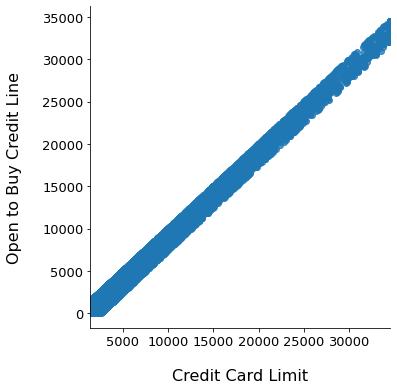

In [4]:
#To visually represent the relationship between 'CreditCard_Limit' and 'CreditLine_Avg_12month'
sns.lmplot(x="CreditCard_Limit", y="CreditLine_Avg_12month", data=bank);
plt.xlabel('Credit Card Limit', size=16, labelpad=20)
plt.ylabel('Open to Buy Credit Line', size=16, labelpad=20) 
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

Based on the very strong correlation of 1 found in the correlation heatmap and the almost perfect positive linear relationship (i.e. data points are found along a diagonal line) found in the scatter plot above, we decided to drop a redundant variable to avoid multicollinearity in our model. We kept 'CreditCard_Limit' and dropped 'CreditLine_Avg_12month' from our dataset.

In [5]:
#Drop "CreditLine_Avg_12month" column since it has perfect correlation with "CreditCard_Limit" column
bank=bank.drop(['CreditLine_Avg_12month'], axis=1)

## Dealing with missing values


### Income Category
Within the 'Income_Category' attribute, 1112 customers (roughly 11%) have no specific income category listed. 

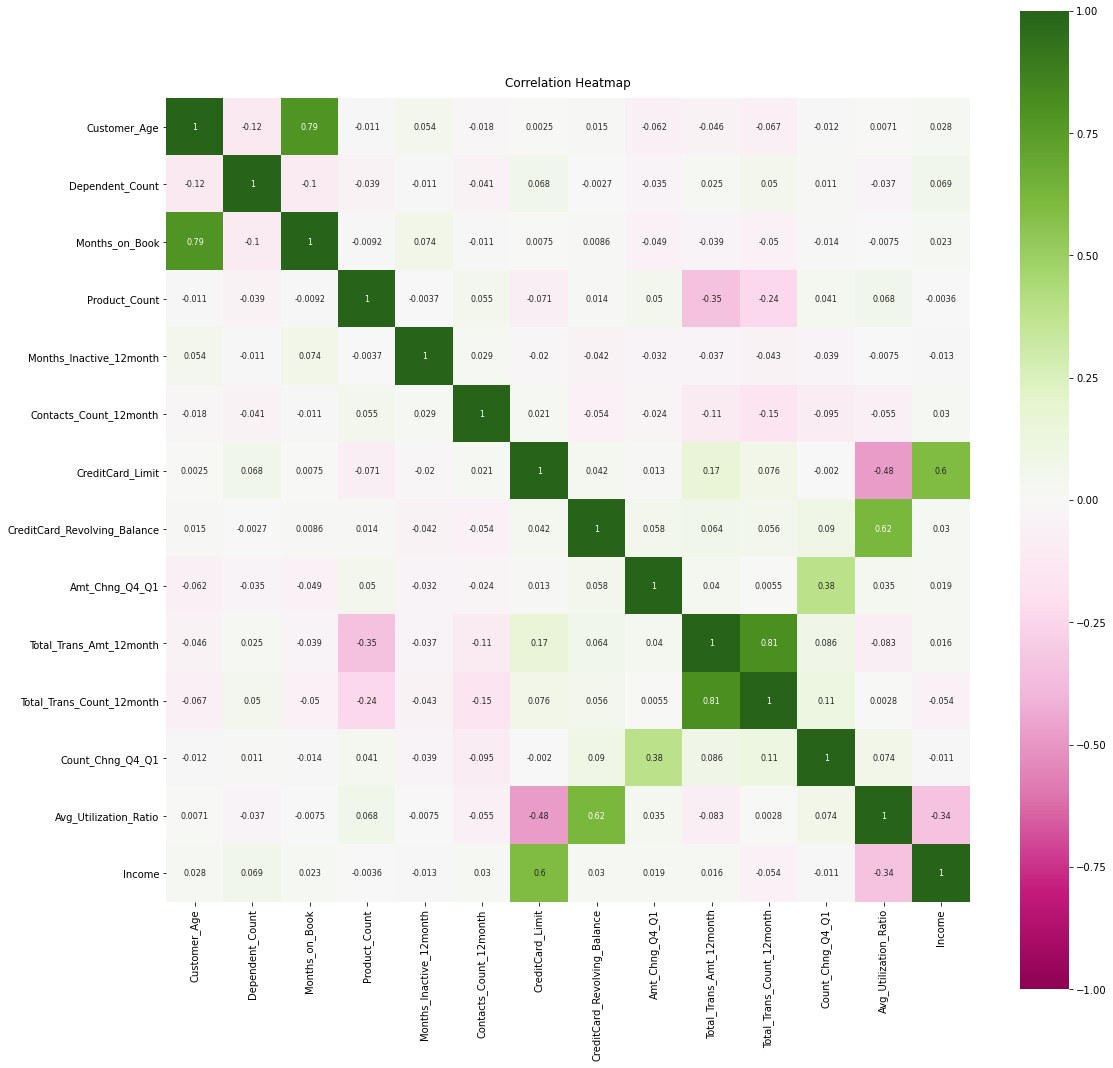

In [6]:
#Convert the income attribute, 'Income_Category' into ordinal data (i.e. numerical values) in order for the attribute to appear in the heatmap (and later on in the models)
income = {"Less than $40K":0, "$40K - $60K":1, "$60K - $80K":2,"$80K - $120K":3, "$120K +":4}
data = [bank]

for dataset in data:
    dataset['Income'] = dataset['Income_Category'].map(income)

#correlation heatmap
plt.figure(figsize=(18,18))

heatmap = sns.heatmap(bank.corr(), 
            annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
            square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
            cmap = 'PiYG', #matplotlib colormap name 
            vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
            vmax = 1,
            annot_kws = {'size':8}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

Missing values in 'Income_Category' are filled with the most common values for customers within the same 'Gender' group and within the same 'CreditCard_Limit' bin. The 'Gender' attribute was selected to group a customer with missing 'Income_Category' values since based on a chi-square test (shown below) there is a significant (p-value < 0.001) relationship between income category and gender. Female customers were found to be within the lower income categories, there were no female customers listed with an income greater than $60,000. The 'CreditCard_Limit' attribute was also selected because based on the heatmap above there is a medium correlation between 'Income' (numerical values of the categorical attribute 'Income_Category') and 'CreditCard_Limit' (r = 0.6). Please note we also did investigate whether a customer's 'Income_Category' was significantly influenced by their 'Education_Level' (shown below) and found there was no significant (p-value > 0.05) relationship between these two attributes. This was surprising since we had intially assumed that customers with a higher level of education would have a higher income. 

In [7]:
IncomebyGender = pd.crosstab(bank['Income_Category'],bank['Gender'])
IncomebyGender #female customers had significantly lower income categories relative to male customers

Gender,F,M
Income_Category,,
$120K +,0,727
$40K - $60K,1014,776
$60K - $80K,0,1402
$80K - $120K,0,1535
Less than $40K,3284,277


In [8]:
stat, p, dof, expected = chi2_contingency(IncomebyGender)
#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject HO)


In [9]:
IncomebyEducation = pd.crosstab(bank['Income_Category'],bank['Education_Level'])
IncomebyEducation

Education_Level,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated
Income_Category,,,,,,
$120K +,70,37,204,147,30,119
$40K - $60K,183,70,553,355,111,249
$60K - $80K,132,59,422,307,77,195
$80K - $120K,175,57,478,308,81,217
Less than $40K,345,158,1139,671,170,522


In [10]:
IncomebyEducation_pct = pd.crosstab(bank['Income_Category'],bank['Education_Level'], normalize='index') #percentages by 'Income_Category' (row)
IncomebyEducation_pct #no large differences in the percent values within each education level across the income categories 

Education_Level,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated
Income_Category,,,,,,
$120K +,0.115321,0.060956,0.336079,0.242175,0.049423,0.196046
$40K - $60K,0.120316,0.046022,0.363577,0.233399,0.072978,0.163708
$60K - $80K,0.110738,0.049497,0.354027,0.257550,0.064597,0.163591
$80K - $120K,0.132979,0.043313,0.363222,0.234043,0.061550,0.164894
Less than $40K,0.114809,0.052579,0.379035,0.223295,0.056572,0.173710


In [11]:
stat, p, dof, expected = chi2_contingency(IncomebyEducation) #no significant relationship between income category and education level
#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

p value is 0.2274305071492602
Independent (H0 holds true)


(13563.0, 34516.0]    2026
(1437.0, 2307.0]      2026
(6279.0, 13563.0]     2025
(3398.0, 6279.0]      2025
(2307.0, 3398.0]      2025
Name: CreditCard_Limit_Group, dtype: int64

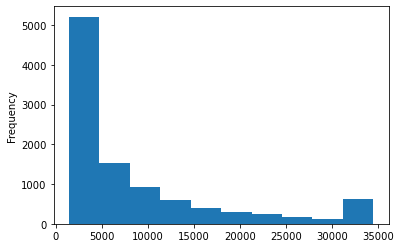

In [12]:
#Grouping by CreditCard_Limit 
#If we cut the range of the 'Credit_Card_Limit' values into a few equally big categories, a disproportinately large number (i.e. greater than 70%) of the values would fall into the first two categories
#We used sklearn “qcut()” function to form five categories with relatively equal number of values within each category
bank['CreditCard_Limit'].plot(kind='hist');
bank['CreditCard_Limit_Group'] = pd.qcut(bank['CreditCard_Limit'], q=5, precision=0)
bank['CreditCard_Limit_Group'].value_counts()

In [13]:
income_by_genderandcreditlimit = bank.groupby(['CreditCard_Limit_Group','Gender'])['Income_Category'].agg(['count'])
income_by_genderandcreditlimit

count
CreditCard_Limit_Group Gender       
(1437.0, 2307.0]       F        1447
                       M         440
(2307.0, 3398.0]       F        1280
                       M         569
(3398.0, 6279.0]       F         928
                       M         857
(6279.0, 13563.0]      F         527
                       M        1188
(13563.0, 34516.0]     F         116
                       M        1663

In [14]:
#Fill the missing values of 'Income_Category'
bank['Income_Category'] = bank.groupby(['CreditCard_Limit_Group','Gender'])['Income_Category'].transform(lambda x: x.fillna(x.mode()[0]))
bank['Income_Category'].isnull().sum() #now there are no missing values for 'Income_Category'

0

In [15]:
#Re-run the following for loop so that the missing values of 'Income' are filled as well
for dataset in data:
    dataset['Income'] = dataset['Income_Category'].map(income)

bank['Income'].isnull().sum() #now there are no missing values for 'Income'

0

### Education Level

Within the 'Education_Level' attribute, there were 1,519 customers (roughly 15%) that had no specific level of education listed. 

In [16]:
#replace missing values for 'Education_Level' with the mode
bank['Education_Level'].fillna(bank['Education_Level'].mode()[0], inplace=True)

### Marital Status
Within the 'Marital_Status' attribute, 749 customers (roughly 7%) have no specific marital status listed.

In [17]:
#replace missing values of 'Marital_Status' with the mode
bank['Marital_Status'].fillna(bank['Marital_Status'].mode()[0], inplace=True)

# Data Exploration and Visualization (EDA)


## Categorical Data

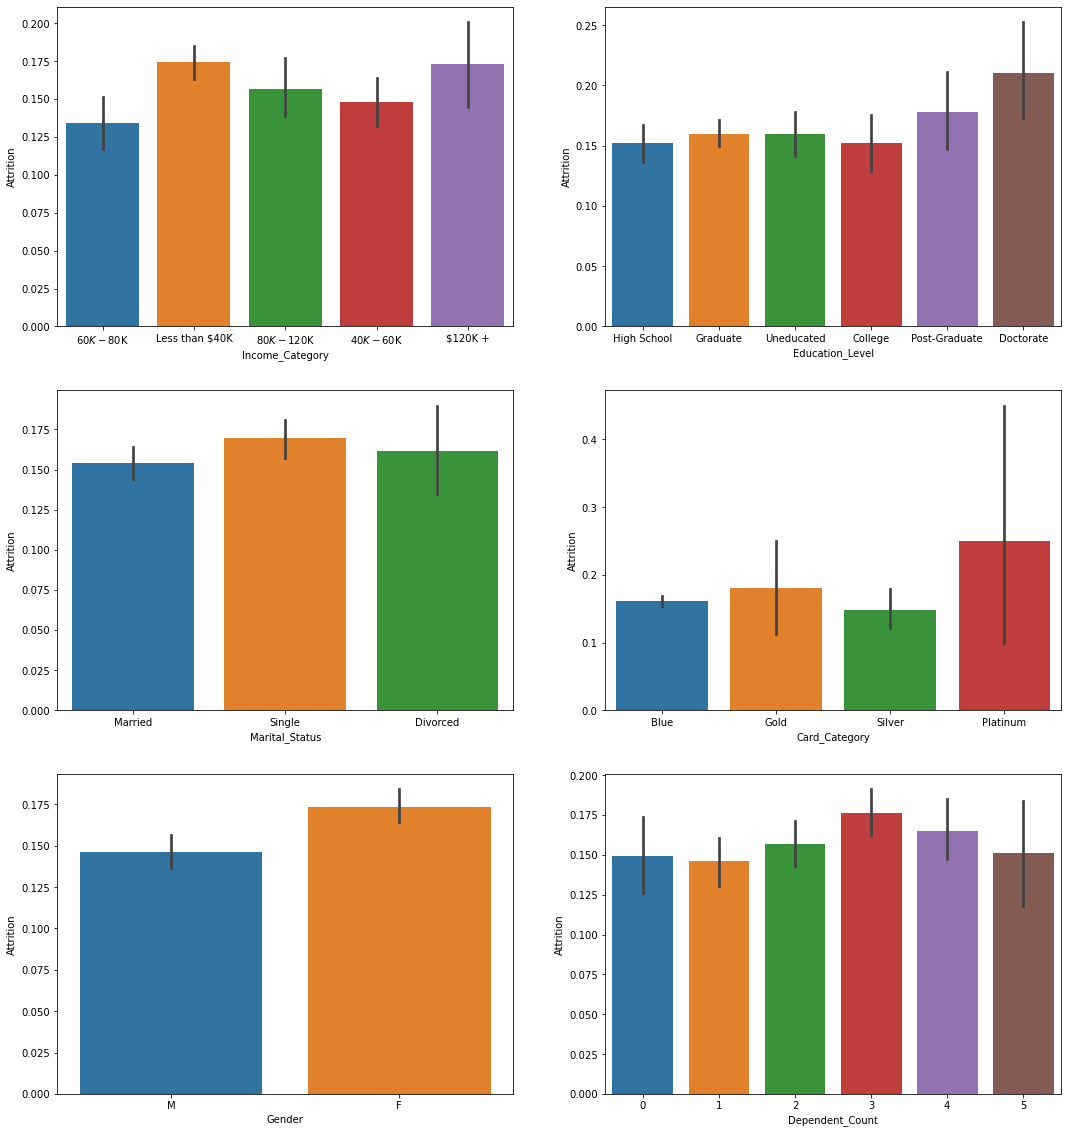

In [18]:
income #Convert the categorical target attribute, 'Attrition_Flag', into a numerical attribute
attrition = {"Existing Customer":0, "Attrited Customer":1}
data = [bank]
# for dataset in data:
dataset['Attrition'] = dataset['Attrition_Flag'].map(attrition)
    
#don't drop 'Attrition_Flag' from bank dataset since this attribute is necessary for some of the figures/statistical tests below

#Figure:
fig,[[ax1, ax2],[ax3, ax4],[ax5, ax6]] = plt.subplots(3,2, figsize=(18,20)) #3 rows, 2 columns
sns.barplot(x='Income_Category', y='Attrition', ax=ax1, data=bank)
sns.barplot(x='Education_Level', y='Attrition', ax=ax2, data=bank)
sns.barplot(x='Marital_Status', y='Attrition', ax=ax3, data=bank)
sns.barplot(x='Card_Category', y='Attrition', ax=ax4, data=bank)
sns.barplot(x='Gender', y='Attrition', ax=ax5, data=bank)
sns.barplot(x='Dependent_Count', y='Attrition', ax=ax6, data=bank)


plt.show()

### Gender

There is a significant difference (p-value < 0.001) between the number of females and males that left the credit card services of the bank. Of the customers that left the credit card company, there were significantly more females than males (see chi-square test below).

In [19]:
contingency = pd.crosstab(bank['Attrition_Flag'],bank['Gender'])
contingency 
#930 females and 697 males left the credit card services of the bank

Gender,F,M
Attrition_Flag,,
Attrited Customer,930,697
Existing Customer,4428,4072


In [20]:
contingency_pct = pd.crosstab(bank['Gender'],bank['Attrition_Flag'], normalize='index')
contingency_pct
#17.4% of all females left the bank while only 14.6% of all males left the bank

Attrition_Flag,Attrited Customer,Existing Customer
Gender,,
F,0.173572,0.826428
M,0.146152,0.853848


In [21]:
contingency_pct = pd.crosstab(bank['Attrition_Flag'],bank['Gender'], normalize='index')
contingency_pct
#57.2% of the total customers that left were females and 42.8% of the total customers that left were males

Gender,F,M
Attrition_Flag,,
Attrited Customer,0.571604,0.428396
Existing Customer,0.520941,0.479059


In [22]:
#chi-square test of independence for gender and attrition
#there is a significant relationship between gender and whether a customer left the bank (p-value < 0.001)
stat, p, dof, expected = chi2_contingency(contingency)

#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

p value is 0.00019635846717310269
Dependent (reject HO)


### Income Category

There is a significant relationship between income category and whether a customer left the bank (p-value < 0.01). Across each income bracket, customers were more likely to stay with the bank then leave. Based on the chi square test below and the figure above, the significant difference within 'Income_Category' and 'Attrition_Flag' is that customers in the less than 40K income bracket had a significantly higher number of customers churn relative to customers within the 60K to 80K income bracket.

Rectangle(xy=(-0.4, 0), width=0.4, height=1241, angle=0)
Rectangle(xy=(0.6, 0), width=0.4, height=3629, angle=0)
Rectangle(xy=(1.6, 0), width=0.4, height=1312, angle=0)
Rectangle(xy=(2.6, 0), width=0.4, height=1717, angle=0)
Rectangle(xy=(3.6, 0), width=0.4, height=601, angle=0)
Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=192, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=766, angle=0)
Rectangle(xy=(2, 0), width=0.4, height=244, angle=0)
Rectangle(xy=(3, 0), width=0.4, height=299, angle=0)
Rectangle(xy=(4, 0), width=0.4, height=126, angle=0)


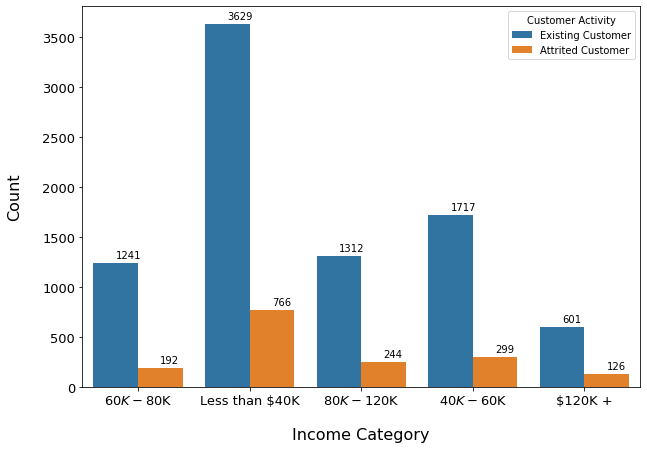

In [23]:
#Data analysis of attrittion flag and income category
plt.figure(figsize=(10,7))
plot=sns.countplot(x=bank.Income_Category,hue = bank.Attrition_Flag)
plt.xlabel('Income Category', size=16, labelpad=20)
plt.ylabel('Count', size=16, labelpad=20) 
plt.legend(title = "Customer Activity")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

for p in plot.patches:
    print(p)
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2,p.get_height()+50))
plt.show()

In [24]:
#chi-square test of independence for income category and attrition
#there is a significant relationship between income category and whether a customer left the bank (p-value < 0.01)
contingency_2 = pd.crosstab(bank['Income_Category'],bank['Attrition_Flag'])
stat, p, dof, expected = chi2_contingency(contingency_2)
print(contingency_2)

#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

Attrition_Flag   Attrited Customer  Existing Customer
Income_Category                                      
$120K +                        126                601
$40K - $60K                    299               1717
$60K - $80K                    192               1241
$80K - $120K                   244               1312
Less than $40K                 766               3629
p value is 0.0019954269576105688
Dependent (reject HO)


In [25]:
IncomebyAttrition_pct = pd.crosstab(bank['Income_Category'],bank['Attrition_Flag'], normalize='index')
IncomebyAttrition_pct
#e.g. 17.3% of customers within the $120K income bracket churned while 82.7% of customers wihtin the same income bracket stayed with the bank
#across each income bracket, customers were more likely to stay with the bank then leave 
##based on this chi square test and the figure above, the significant difference within Income_Category and Attrition_Flag is that customers in the less than $40K income bracket had a significantly higher number of customers churn relative to customers within the $60K to $80K income bracket

Attrition_Flag,Attrited Customer,Existing Customer
Income_Category,,
$120K +,0.173315,0.826685
$40K - $60K,0.148313,0.851687
$60K - $80K,0.133985,0.866015
$80K - $120K,0.156812,0.843188
Less than $40K,0.174289,0.825711


### Education Level

There is a significant relationship between education level and customer churn (p-value < 0.05). Based on this chi square test below and the figure above, customers that hold a doctorate degree had a significantly higher attrition rate relative to customers that only hold a high school or graduate level degree.

In [26]:
#contingency table of education level and attrition
contingency_3 = pd.crosstab(bank['Education_Level'],bank['Attrition_Flag'])

#chi-square test of independence for education level and attrition
#there is a significant relationship between education level and attrition (p-value < 0.05)
stat, p, dof, expected = chi2_contingency(contingency_3)

#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

#based on this chi square test and the figure above, customers that hold a doctorate degree had a significantly higher attrition rate relative to customers that only hold a high school or graduate level degree

p value is 0.046446360120696625
Dependent (reject HO)


There is no significant difference (see chi-square tests below) between the marital status, type of credit card, or number of dependents between the customers that left the bank and those that have stayed. 

### Marital Status

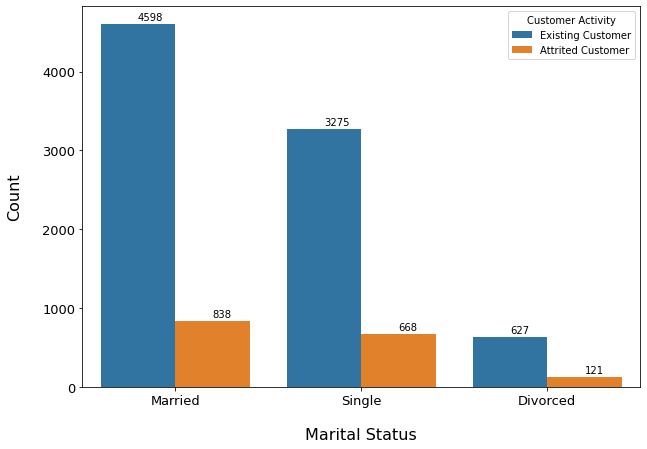

In [27]:
#Data analysis of attrittion flag and marital status
plt.figure(figsize=(10,7))
plot=sns.countplot(x=bank.Marital_Status,hue=bank.Attrition_Flag)
plt.xlabel('Marital Status', size=16, labelpad=20)
plt.ylabel('Count', size=16, labelpad=20) 
plt.legend(title = "Customer Activity")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2,p.get_height()+50))
plt.show()

In [28]:
#chi-square test of independence for marital status and attrition
contingency_4 = pd.crosstab(bank['Marital_Status'],bank['Attrition_Flag'])
print(contingency_4)

stat, p, dof, expected = chi2_contingency(contingency_4)
print(p) #p-value > 0.05 therefore there is no significant relationship between marital status and attrition


Attrition_Flag  Attrited Customer  Existing Customer
Marital_Status                                      
Divorced                      121                627
Married                       838               4598
Single                        668               3275
0.13861464842880653


### Card Category

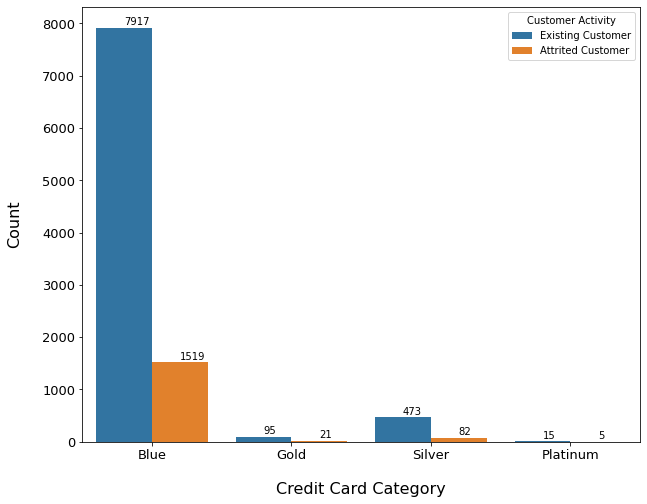

In [29]:
#Data analysis of attrittion flag and card category
plt.figure(figsize=(10,8))
plot=sns.countplot(x=bank.Card_Category,hue=bank.Attrition_Flag)
plt.xlabel('Credit Card Category', size=16, labelpad=20)
plt.ylabel('Count', size=16, labelpad=20) 
plt.legend(title = "Customer Activity")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2,p.get_height()+50))
plt.show()

In [30]:
#chi-square test of independence for credit card type and attrition
contingency_5 = pd.crosstab(bank['Card_Category'],bank['Attrition_Flag'])
print(contingency_5)

stat, p, dof, expected = chi2_contingency(contingency_5)
print(p) #p-value > 0.05 therefore there is no significant relationship between credit card type and attrition

Attrition_Flag  Attrited Customer  Existing Customer
Card_Category                                       
Blue                         1519               7917
Gold                           21                 95
Platinum                        5                 15
Silver                         82                473
0.5252382797994759


In [31]:
# Attrition by card category 
AttritionbyCardCategory_pct= pd.crosstab(bank['Card_Category'],bank['Attrition_Flag'], normalize='index')
AttritionbyCardCategory_pct

Attrition_Flag,Attrited Customer,Existing Customer
Card_Category,,
Blue,0.160979,0.839021
Gold,0.181034,0.818966
Platinum,0.250000,0.750000
Silver,0.147748,0.852252


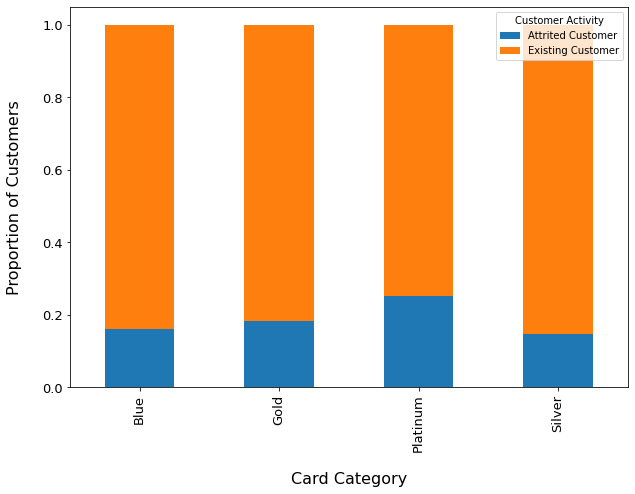

In [32]:
AttritionbyCardCategory_pct.plot(kind='bar',stacked=True, figsize = (10,7))
plt.xlabel('Card Category', size=16, labelpad=20)
plt.ylabel('Proportion of Customers', size=16, labelpad=20) 
plt.legend(title = "Customer Activity")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13);

In [33]:
# Attrition by card category 
AttritionbyCardCategory_pct_2 = pd.crosstab(bank['Attrition_Flag'],bank['Card_Category'], normalize='index')
AttritionbyCardCategory_pct_2

Card_Category,Blue,Gold,Platinum,Silver
Attrition_Flag,,,,
Attrited Customer,0.933620,0.012907,0.003073,0.050400
Existing Customer,0.931412,0.011176,0.001765,0.055647


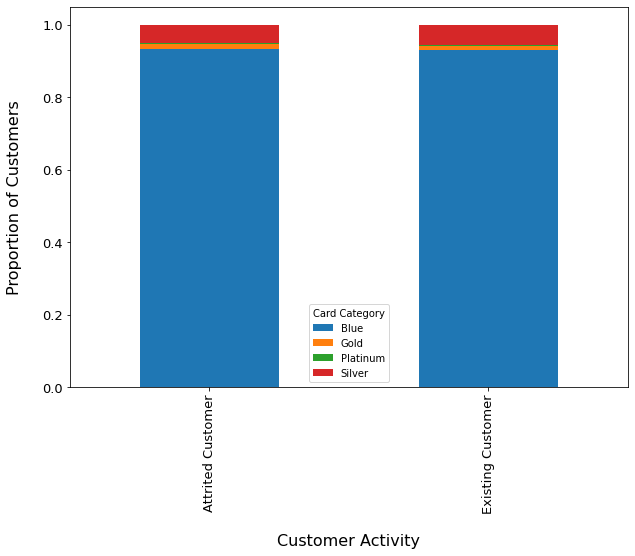

In [34]:
AttritionbyCardCategory_pct_2.plot(kind='bar',stacked=True, figsize = (10,7))
plt.xlabel('Customer Activity', size=16, labelpad=20)
plt.ylabel('Proportion of Customers', size=16, labelpad=20) 
plt.legend(title = "Card Category")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13);

Based on the two figures above we find that the highest proportion of customers that left the bank had a Platinum card and the lowest proportion was for customers with a Silver card. However, it is important to note that of the customers that left the bank, the majority had Blue credit cards which is important for the bank since they might not want to lose account holders that could eventually get a higher interest credit card and make greater use of their other products. 

### Number of Dependents

There is no significant relationship (p-value > 0.05) between the number of dependents and attrition.

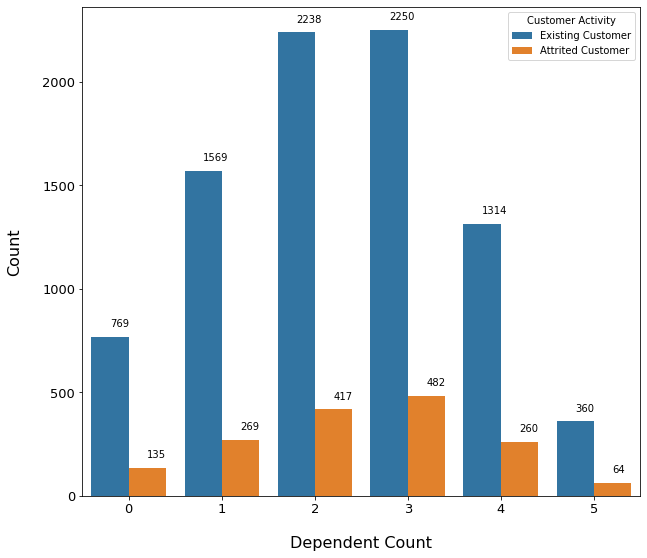

In [35]:
# data analysis of attrittion flag and dependent count
plt.figure(figsize=(10,9))
plot=sns.countplot(x=bank.Dependent_Count,
                   hue=bank.Attrition_Flag)
plt.xlabel('Dependent Count', size=16, labelpad=20)
plt.ylabel('Count', size=16, labelpad=20) 
plt.legend(title = "Customer Activity")
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2,p.get_height()+50))
plt.show()

In [36]:
#chi-square test of independence for number of dependents and attrition
contingency_6 = pd.crosstab(bank['Dependent_Count'],bank['Attrition_Flag'])
print(contingency_6)

stat, p, dof, expected = chi2_contingency(contingency_6)
print(p) #p-value > 0.05 therefore there is no significant relationship between number of dependents and attrition

Attrition_Flag   Attrited Customer  Existing Customer
Dependent_Count                                      
0                              135                769
1                              269               1569
2                              417               2238
3                              482               2250
4                              260               1314
5                               64                360
0.09150463456682643


## Numerical Data

### Add "Grouping/Binning" to aid in visualization

In [37]:
#Binning 'Customer_Age' - categorizing ranges of the data into logical bins to make it a more meaningful analysis
#the youngest customer is 26 and the oldest customer is 73

data = [bank]
for dataset in data:
     dataset.loc[(dataset['Customer_Age'] > 20) & (dataset['Customer_Age'] <= 29), 'Age_Group'] = "20-29" #customers in their 20s
     dataset.loc[(dataset['Customer_Age'] > 29) & (dataset['Customer_Age'] <= 39), 'Age_Group'] = "30-39" #customers in their 30s
     dataset.loc[(dataset['Customer_Age'] > 39) & (dataset['Customer_Age'] <= 49), 'Age_Group'] = "40-49" #customers in their 40s
     dataset.loc[(dataset['Customer_Age'] > 49) & (dataset['Customer_Age'] <= 59), 'Age_Group'] = "50-59" #customers in their 50s
     dataset.loc[(dataset['Customer_Age'] > 59) & (dataset['Customer_Age'] <= 69), 'Age_Group'] = "60-69" #customers in their 60s
     dataset.loc[dataset['Customer_Age'] > 69, 'Age_Group'] = "Over 70" #customers in their 70s

bank['Age_Group'].value_counts()

40-49      4561
50-59      2998
30-39      1841
60-69       530
20-29       195
Over 70       2
Name: Age_Group, dtype: int64

3rd year        5418
4th year        3207
2nd year         847
Over 4 years     655
Name: Months_on_Book_Group, dtype: int64

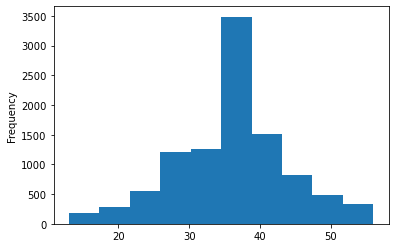

In [38]:
#Binning 'Months_on_Book' - categorizing ranges of the data into logical bins to make it a more meaningful analysis
#the shortest months on the book was 13 months while the customer on the books the longest was for 56 months

bank['Months_on_Book'].plot(kind='hist');

#binning by year
data = [bank]
for dataset in data:
    dataset.loc[(dataset['Months_on_Book'] > 12) & (dataset['Months_on_Book'] <= 24), 'Months_on_Book_Group'] = "2nd year" #at least 1 year on the books (within their second year on the books)
    dataset.loc[(dataset['Months_on_Book'] > 24) & (dataset['Months_on_Book'] <= 36), 'Months_on_Book_Group'] = "3rd year"
    dataset.loc[(dataset['Months_on_Book'] > 36) & (dataset['Months_on_Book'] <= 48), 'Months_on_Book_Group'] = "4th year"
    dataset.loc[dataset['Months_on_Book'] > 48, 'Months_on_Book_Group'] = "Over 4 years" #over 4 years on the books

bank['Months_on_Book_Group'].value_counts()

### Customer Age

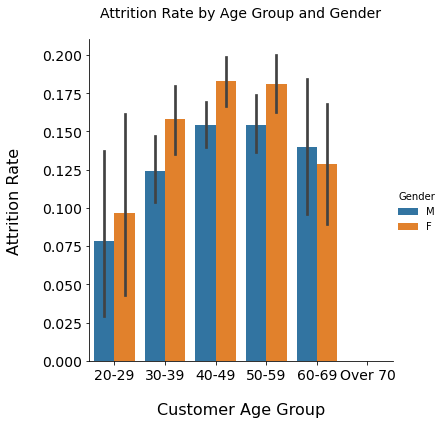

In [39]:
sns.catplot(x='Age_Group',
            y = 'Attrition',
            hue = 'Gender',
            kind = "bar",
            data = bank,
            order = ["20-29","30-39","40-49", "50-59", "60-69", "Over 70"])

plt.xlabel('Customer Age Group', size=16, labelpad=20)
plt.ylabel('Attrition Rate', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.title('Attrition Rate by Age Group and Gender', size=14, y=1.05)

plt.show()
#female customers in theirs 30s, 40s, and 50s tend to have a higher attrition rate (i.e. more left the credit card services) compared to their male counterparts or customers that are younger (in their 20s) or older (in their 60s and 70s)

In [40]:
#contigency table of attrition and customer age group
contingency_table = pd.crosstab(bank['Attrition_Flag'],bank['Age_Group'])

#chi-square test of independence for attrition and customer age group
stat, p, dof, expected = chi2_contingency(contingency_table)

#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

#there is a significant relationship between attrition and customer age group (p-value < 0.01)

p value is 0.0013442425339930553
Dependent (reject HO)


In [41]:
AttritionbyAgeGroup = pd.crosstab(bank['Attrition_Flag'],bank['Age_Group'])
AttritionbyAgeGroup

Age_Group,20-29,30-39,40-49,50-59,60-69,Over 70
Attrition_Flag,,,,,,
Attrited Customer,17,261,772,506,71,0
Existing Customer,178,1580,3789,2492,459,2


In [42]:
AttritionbyAgeGroup_pct = pd.crosstab(bank['Attrition_Flag'],bank['Age_Group'], normalize='index')
AttritionbyAgeGroup_pct

Age_Group,20-29,30-39,40-49,50-59,60-69,Over 70
Attrition_Flag,,,,,,
Attrited Customer,0.010449,0.160418,0.474493,0.311002,0.043639,0.000000
Existing Customer,0.020941,0.185882,0.445765,0.293176,0.054000,0.000235


In [43]:
CardCategorybyAgeGroup = pd.crosstab(bank['Card_Category'],bank['Age_Group'])
CardCategorybyAgeGroup
#the majority of the Silver, Gold, and Platinum card holders are in their 40s and 50s

Age_Group,20-29,30-39,40-49,50-59,60-69,Over 70
Card_Category,,,,,,
Blue,184,1732,4188,2828,502,2
Gold,1,20,67,25,3,0
Platinum,0,1,11,8,0,0
Silver,10,88,295,137,25,0


In [44]:
CardCategorybyAgeGroup_pct = pd.crosstab(bank['Card_Category'],bank['Age_Group'], normalize='index')
CardCategorybyAgeGroup_pct

Age_Group,20-29,30-39,40-49,50-59,60-69,Over 70
Card_Category,,,,,,
Blue,0.019500,0.183552,0.443832,0.299703,0.053201,0.000212
Gold,0.008621,0.172414,0.577586,0.215517,0.025862,0.000000
Platinum,0.000000,0.050000,0.550000,0.400000,0.000000,0.000000
Silver,0.018018,0.158559,0.531532,0.246847,0.045045,0.000000


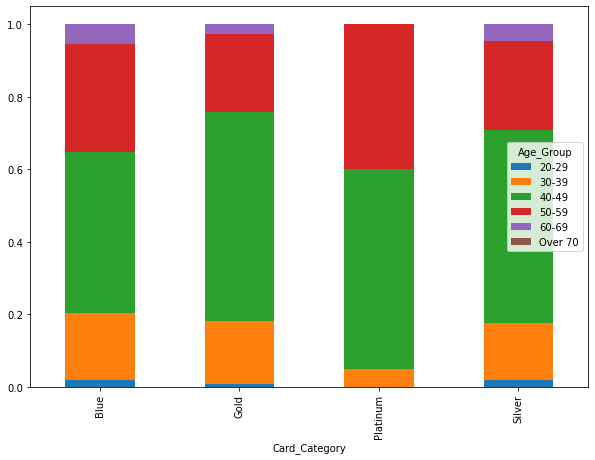

In [45]:
CardCategorybyAgeGroup_pct.plot(kind='bar',stacked=True, figsize = (10,7)); #gives the proportion of customers within each age group for each card type

Based on the figure and tables above, the majority of each of the card holders within each card type were in their 40s. Roughly 95% of all Platinum card holders and approximately 79% of all Gold card holders were in their 40s or 50s. Based on the table below, the Blue credit card was the most popular across all age groups. 




In [46]:
CardCategorybyAgeGroup_pct_2 = pd.crosstab(bank['Age_Group'],bank['Card_Category'], normalize='index')
CardCategorybyAgeGroup_pct_2

Card_Category,Blue,Gold,Platinum,Silver
Age_Group,,,,
20-29,0.943590,0.005128,0.000000,0.051282
30-39,0.940793,0.010864,0.000543,0.047800
40-49,0.918220,0.014690,0.002412,0.064679
50-59,0.943296,0.008339,0.002668,0.045697
60-69,0.947170,0.005660,0.000000,0.047170
Over 70,1.000000,0.000000,0.000000,0.000000


In [47]:
#contigency table of card category and customer age group
contingency_test = pd.crosstab(bank['Card_Category'],bank['Age_Group'])

#chi-square test of independence for card category and customer age group
stat, p, dof, expected = chi2_contingency(contingency_test)

#interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject HO)')
else:
    print('Independent (H0 holds true)')

#there is a significant relationship between card category and customer age group (p-value < 0.05)
#the majority of the Silver, Gold, and Platinum card holders are in their 40s and 50s

p value is 0.011158763423122392
Dependent (reject HO)


### Credit Card Limit

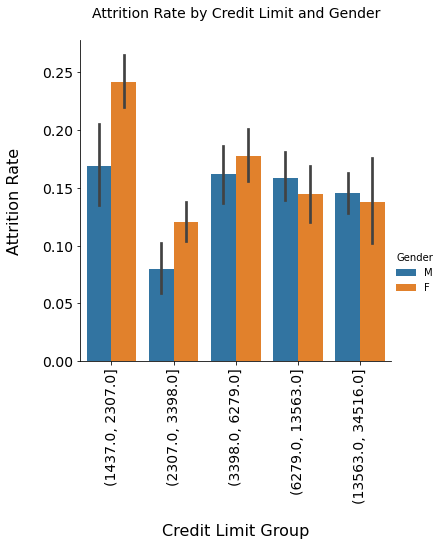

In [48]:
sns.catplot(x='CreditCard_Limit_Group',
            y = 'Attrition',
            hue = 'Gender',
            kind = "bar",
            data = bank)

plt.xlabel('Credit Limit Group', size=16, labelpad=20)
plt.xticks(rotation=90)
plt.ylabel('Attrition Rate', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.title('Attrition Rate by Credit Limit and Gender', size=14, y=1.05)

plt.show()
#more females with lower credit card limits left the bank's credit card services (i.e. higher attrition rate) compared to males within the same three lowest credit card limit groups
#within the two highest credit card limit groups there were slightly more males that attrited than females within the same group
#females in the lowest credit card limit group had the highest attrition rate (almost 1/4 of those customers left the credit card services)

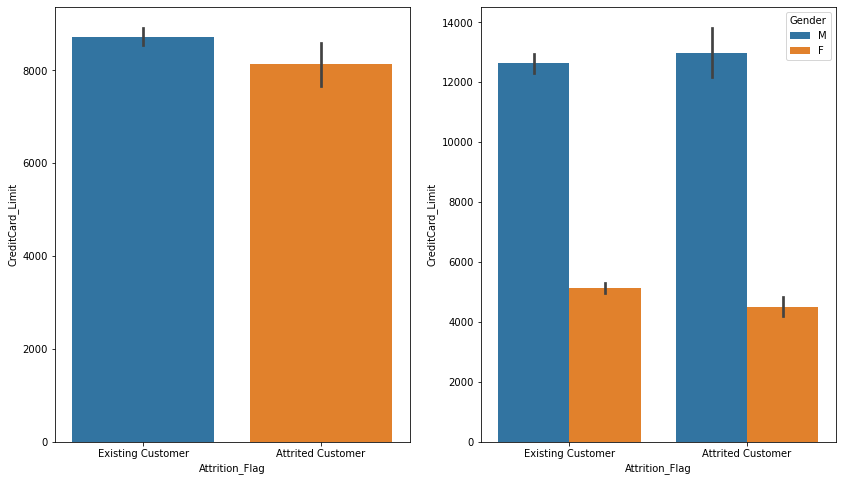

In [49]:
fig,[ax1, ax2] = plt.subplots(1,2, figsize=(14,8)) #1 rows, 2 columns
sns.barplot(x='Attrition_Flag', y='CreditCard_Limit', ax=ax1, data=bank)
sns.barplot(x='Attrition_Flag', y='CreditCard_Limit', hue='Gender', ax=ax2, data=bank)

plt.show()
#there is no large difference in credit card limit between existing customers and those that left the credit card services (i.e. attrited customers)
#male customers tend to have a higher credit card limit compared to female customers (indifferent of whether they stayed or left the credit card services)

### Total Transaction Amount and Count (from the last 12 months)

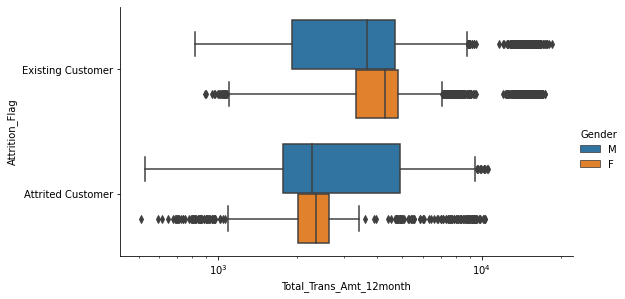

In [50]:
a = sns.catplot(x='Total_Trans_Amt_12month',
                y='Attrition_Flag',
                hue='Gender',
                data = bank.query("Total_Trans_Amt_12month>0"),
                orient="h",
                height=4,
                aspect=2,
                kind="box")
a.set(xscale="log");
#existing customers have a higher mean total transaction amount compared to customers that have attrited, and there does not seem to be any signififcant differences in the total transaction amount based on gender

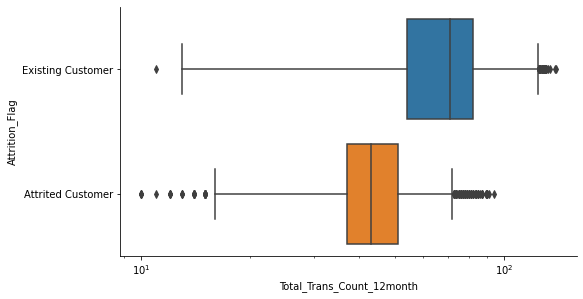

In [51]:
a = sns.catplot(x='Total_Trans_Count_12month',
                y='Attrition_Flag',
                data = bank.query("Total_Trans_Count_12month>0"),
                orient="h",
                height=4,
                aspect=2,
                kind="box")
a.set(xscale="log");
#similar finding as above, total transaction count in the last 12 months is lower for customers that churned relative to customers that stayed with the bank

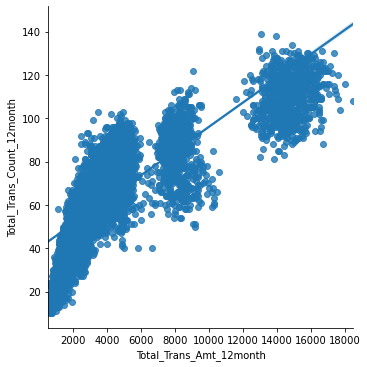

In [52]:
#to visually represent the relationship between 'Total_Trans_Amt_12month' and 'Total_Trans_Count_12month' (based on the heatmap they are strongly correlated)
sns.lmplot(x="Total_Trans_Amt_12month", y="Total_Trans_Count_12month", data=bank);
#there is a positive linear relationship between these two attributes

### Credit Card Revolving Balance

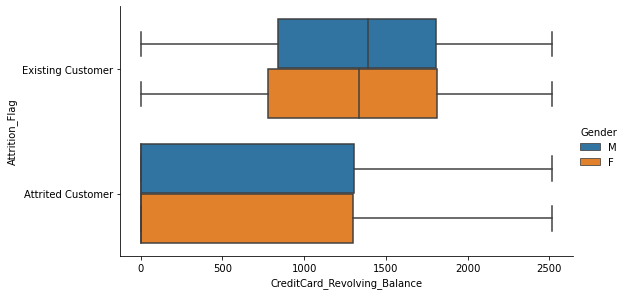

In [53]:
sns.catplot(x='CreditCard_Revolving_Balance',
                y='Attrition_Flag',
                orient="h",
                height=4,
                aspect=2,
                kind="box",
                hue = "Gender",
                data=bank);
#existing customers have a higher mean credit card revolving balance compared to customers that have attrited, and gender has no affect on a customer's credit car revolving balance

### Product Count (Total number of products held by the customer)

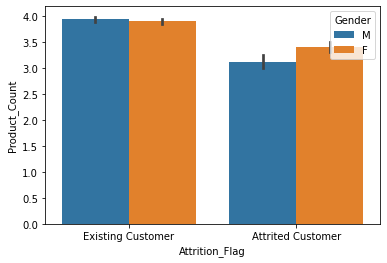

In [54]:
sns.barplot(x="Attrition_Flag", y="Product_Count", hue = "Gender", data=bank);

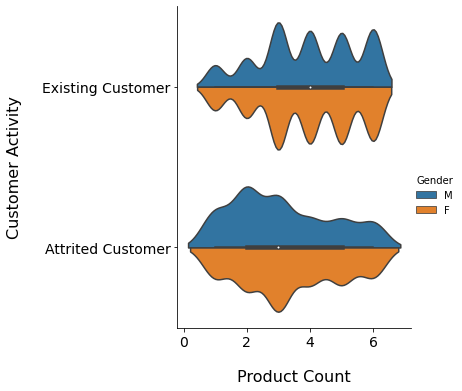

In [55]:
sns.catplot(x="Product_Count", 
            y="Attrition_Flag",
            hue="Gender",
            kind="violin",
            split=True, 
            data=bank)
plt.xlabel('Product Count', size=16, labelpad=20)
plt.ylabel('Customer Activity', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14);
#based on this plot and the one above, existing customers had a higher mean number of products compared to churned customers (i.e. existing customers predominantly had 3 or more products)
#of the customers that left the bank, the majority of males had just over two products while females had roughly 3 products 

### Average Card Utilization Ratio

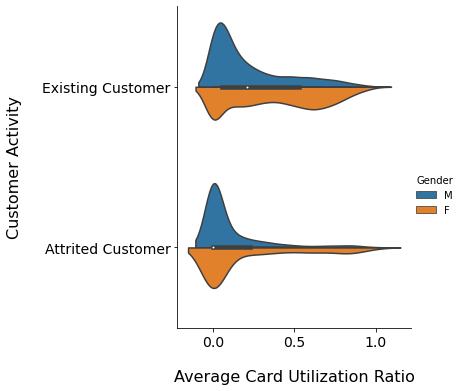

In [56]:
sns.catplot(x="Avg_Utilization_Ratio", 
            y="Attrition_Flag",
            kind="violin",
            hue="Gender",
            split=True, 
            data=bank)
plt.xlabel('Average Card Utilization Ratio', size=16, labelpad=20)
plt.ylabel('Customer Activity', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14);

#based on this figure, existing customers have a slightly higher mean average card utilization ratio compared to attrited customers
#existing female customers have a wider range card average utilization ratio compared to their male counterparts or any of the attrited customers  

### Change in Transaction Amount and Count (Q4 over Q1) 

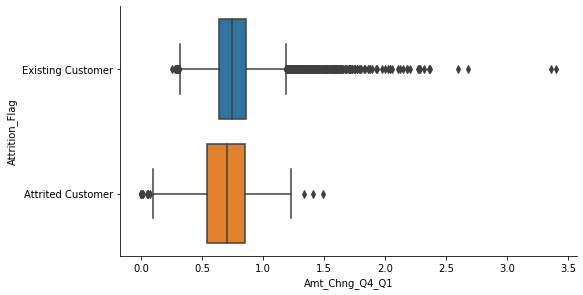

In [57]:
sns.catplot(x='Amt_Chng_Q4_Q1',
                y='Attrition_Flag',
                orient="h",
                height=4,
                aspect=2,
                kind="box",
                data=bank);
#no large difference in the change in transaction amount for existing and attrited customers

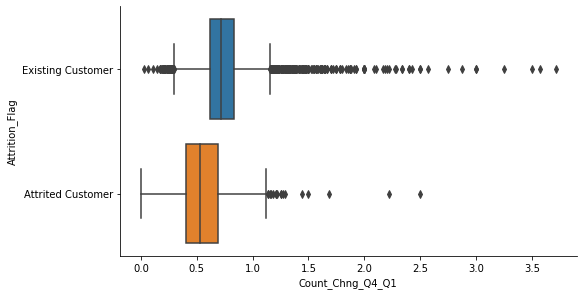

In [58]:
sns.catplot(x='Count_Chng_Q4_Q1',
                y='Attrition_Flag',
                orient="h",
                height=4,
                aspect=2,
                kind="box",
                data=bank);
#existing customers had a higher mean change in transaction count compared to attrited customers

### Months on the Book (Period of relationship with bank) and Months Inactive (Number of months inactive in the last 12 months)

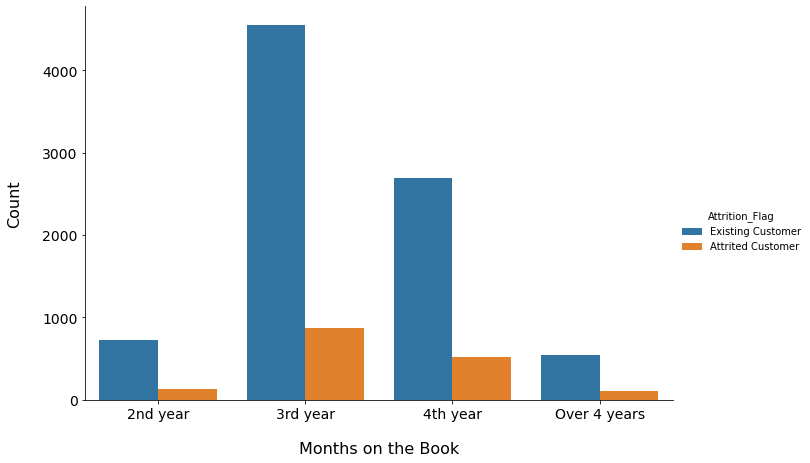

In [59]:
sns.catplot(x="Months_on_Book_Group",
            hue="Attrition_Flag",
            kind="count",
            data=bank,
            order = ["2nd year","3rd year","4th year", "Over 4 years"], height=6, aspect=1.5)
plt.xlabel('Months on the Book', size=16, labelpad=20)
plt.ylabel('Count', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14);

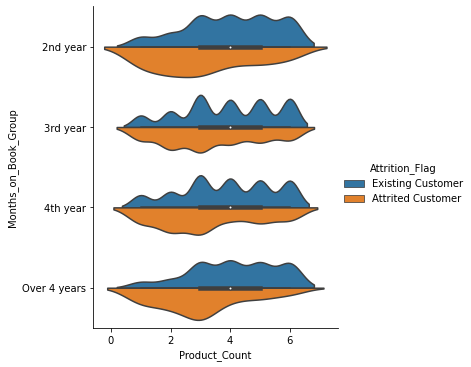

In [60]:
sns.catplot(x="Product_Count", 
            y="Months_on_Book_Group",
            kind="violin",
            hue="Attrition_Flag",
            order = ["2nd year","3rd year","4th year", "Over 4 years"],
            split=True, 
            data=bank);
#violin plot below provides a good perspective of the bank business (shows high/low points, waves)
#a customer with more than 2 and less than 4 products with bank had significant tendency to leave bank
#customers who were in their second year with the bank had a higher tendency of leaving before they had 3 products with the bank
#customers in their third or fourth year with the bank did not have a clear relationship between the number of products they had with the bank and when they left
#customers who had been with the bank for at least 4 years tended to leave once they had 3 products with the bank

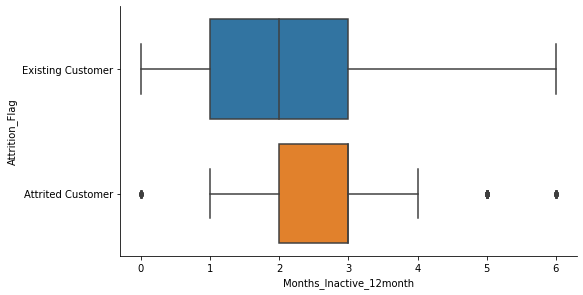

In [61]:
sns.catplot(x='Months_Inactive_12month',
                y='Attrition_Flag',
                orient="h",
                height=4,
                aspect=2,
                kind="box",
                data=bank);
#no visible difference in the number of months inactive between existing and attrited customers 

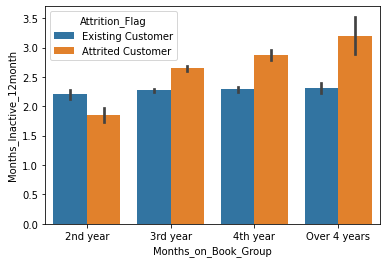

In [62]:
sns.barplot(x="Months_on_Book_Group",
            y="Months_Inactive_12month",
            hue="Attrition_Flag",
            data=bank,
            order = ["2nd year","3rd year","4th year", "Over 4 years"]);
#the rate of attrition increased the longer the customers had been with the bank and the longer the customers had been inactive 

# Feature Engineering
Machine learning models work best with numeric values, therefore the categorical attributes must be converted into numeric values. The categorical variable 'Attrition_Flag' was converted into a numerical attribute with 0 representing an existing customer and 1 representing an attrited customer and is now represented by the attribute 'Attrition'. The code for how this was down is shown above in the subsection "Data Exploration and Visualization (EDA)". The categorical variable 'Income_Category' was converted into ordinal data (i.e. numeric values) and is now represented by the attribute 'Income' and the code for that is shown above in the subsection 'Dealing with missing values'. Lastly, we converted the remaining categorical data ('Gender', 'Education_Level', 'Marital_Status', and 'Card_Category') into dummy variables. 

##Convert categorical columns into dummy variables

It is important to avoid falling into the "Dummy variable trap" since that can cause redundancy in your dataset which can cause a multicollinearity problem.

In [63]:
#Create dummy variables (for all other categorical attributes) without falling into the dummy trap
#the dummy variable trap = in a datset that contains variable with two unique values, creating dummy variables for both of them would be redundant and this could cause a multicollinearity problem
#'dummies' contain column names that we want to convert into numeric values - each variable in them will become a column, and their absence will define as 0, and 1 when they are true for that customer or not
bank_model=pd.get_dummies(bank,columns=['Gender', 'Education_Level','Marital_Status','Card_Category'],drop_first=True)


## Convert categorical y into a numerical attribute

The target variable 'Attrition_Flag' was converted in a numerical attribute 'Attrition' in the previous section (i.e. Data Visualization and Exploration > Categorical Data).

## Drop categorical columns (i.e. keep its numerical counterpart)

In [64]:
# Drop the following columns for running the models
# Using Income so drop Income_Category;
# Using CreditCard_Limit instead of CreditCard_Limit_Group 
# Using Customer Age so drop Age_Group; 
# Using Months_on_Book instead of Months_on_Book_Group
# Using Attrition instead of Attrition_Flag
bank_model=bank_model.drop([
                            'Income_Category','CreditCard_Limit_Group',
                            'Age_Group','Months_on_Book_Group',
                            'Attrition_Flag'
                            ], axis=1)
bank_model.head()

,Customer_Age,Dependent_Count,Months_on_Book,Product_Count,Months_Inactive_12month,Contacts_Count_12month,CreditCard_Limit,CreditCard_Revolving_Balance,Amt_Chng_Q4_Q1,Total_Trans_Amt_12month,...,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
Client_Num,,,,,,,,,,,,,,,,,,,,,
768805383,45,3,39,5,1,3,12691.0,777,1.335,1144,...,0,0,1,0,0,1,0,0,0,0
818770008,49,5,44,6,1,2,8256.0,864,1.541,1291,...,0,1,0,0,0,0,1,0,0,0
713982108,51,3,36,4,1,0,3418.0,0,2.594,1887,...,0,1,0,0,0,1,0,0,0,0
769911858,40,4,34,3,4,1,3313.0,2517,1.405,1171,...,0,0,1,0,0,1,0,0,0,0
709106358,40,3,21,5,1,0,4716.0,0,2.175,816,...,0,0,0,0,1,1,0,0,0,0


# Model Building
The objective of the model is to predict customers who are likely to leave the bank’s credit card services so that the bank can take actions to prevent those customers from leaving. First, we need to divide the dataset into random training and test subsets by splitting the original dataset into 80% training and 20% test. Since the dataset is imbalanced we did stratified sampling therefore both the training and test datasets will have similar portions of the target (i.e. 'Attrition') classes as the complete dataset.

## Assign X, y &Train/Test Split

In [65]:
#X contains independent attributes, y contains dependent attributes
X = bank_model.drop('Attrition', axis=1)
y = bank_model['Attrition']

#split the dataset into 80% training and 20% test
#"stratify = y" will  keep (approximately) the proportion of y values through the training and test sets, it enables stratified splitting
#stratified splits are desirable when classifying an imbalanced dataset (i.e. a dataset with a significant difference in the number of samples that belong to the specific classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


## F1-score instead of accuracy score because of the imbalanced dataset

In [71]:
# To check how imbalanced our test set is:
(y_test.value_counts()[0]/y_test.value_counts().sum()).round(2)
#84% will be used as the model accuracy threshold, any model below that is worse than just guessing

0.84

We trained several machine learning models and compared their results. The machine learning models we used were logistic regression, K nearest neighbor classification, random forest, gaussian naive bayes, and decision tree classification. In addition to measuring the accuracy of each of the models we also measured the F1-score. Due to the imbalanced class distribution in our dataset, the F1-score provides a better metric to evaluate our models.

## Feature scaling is needed for some of the models

Feature scaling is important for some models to make sure that all the attributes are on a comparable scale so that features with large values will not have greater weight than attributes with smaller values. 

In [72]:
#Need to normalize the data (feature scaling) using the 'StandardScalar' function
#standardization, or Z-score normalization involves scaling the data so that the mean is zero and variance is 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model

In [73]:
#Now build the Logistic Classifier
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_predicted_train = log_reg.predict(X_train_scaled)
y_predicted_test = log_reg.predict(X_test_scaled)

f1_log_reg_train=(f1_score(y_train, y_predicted_train, zero_division=1)).round(3)
f1_log_reg_test=(f1_score(y_test, y_predicted_test, zero_division=1)).round(3)


print(f1_log_reg_train)
print(f1_log_reg_test)

0.664
0.661


In [74]:
print('\nClassification Report')
print(classification_report(y_test, y_predicted_test))


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1701
           1       0.82      0.55      0.66       325

    accuracy                           0.91      2026
   macro avg       0.87      0.77      0.80      2026
weighted avg       0.90      0.91      0.90      2026



In [75]:
#coefficients from the model
log_reg.coef_

array([[ 1.03199798e-02,  1.79924432e-01, -6.11448851e-02,
        -7.30661301e-01,  5.19236443e-01,  5.90919545e-01,
        -1.82185306e-01, -7.34055980e-01, -9.60298543e-02,
         1.67555572e+00, -2.77666094e+00, -6.79862402e-01,
        -5.94833564e-02,  2.62069249e-01, -4.96708338e-01,
         6.99742823e-02, -1.33315402e-02, -4.87792419e-02,
        -2.51024131e-03, -2.65340420e-02, -2.24151745e-01,
        -5.95196625e-04,  1.05560241e-01,  4.52874570e-02,
         1.29138469e-01]])

Total_Trans_Amt_12month has a coefficient of 1.68 and Total_Trans_Count_12month has a coefficient of -2.79 and as such have the greatest influence on the model.

In [76]:
#since Logistic Regression performs poorly with independent variables that are not correlated to the target and are correlated to each other (i.e. high multicollinearity) 
#model was re-run using the lower multicollinearity dataset 'bank_model_2' 
#see 'Checking for Multicollinearity' section for why X_4 was selected

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_4, y, test_size = 0.2, random_state = 0, stratify = y)

scaler_2 = StandardScaler()
scaler_2.fit(X_train_2)
X_train_scaled_2 = scaler_2.transform(X_train_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled_2, y_train_2)
y_predicted_train_2 = log_reg.predict(X_train_scaled_2)
y_predicted_test_2 = log_reg.predict(X_test_scaled_2)
f1_log_reg_train_2=(f1_score(y_train_2, y_predicted_train_2, zero_division=1)).round(3)
f1_log_reg_test_2=(f1_score(y_test_2, y_predicted_test_2, zero_division=1)).round(3)

#print(accuracy_log_reg)
print(f1_log_reg_train_2)
print(f1_log_reg_test_2)

0.477
0.493


In this case the Logistic Regression model worked best even when there was non-independence in the attributes. As such, the benefit of removing attributes to lower multicollinearity in the dataset did not outweight the information brought by those features to the model. Overall, the Logistic Regression model has an F1-score of 0.661 for the testing dataset.

## K Nearest Neighbor Classification Model

In [77]:
#Used the standardized data above (i.e. feature scaling)
#K Nearest Neighbor Classification
k_range = range(1,21) #try k=1 through k=20 and record testing accuracy
test_scores_f1 =[]
train_scores_f1 =[]
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  y_pred_test = knn.predict(X_test_scaled)
  y_pred_train = knn.predict(X_train_scaled)
  test_scores_f1.append(f1_score(y_test, y_pred_test, zero_division=1))
  train_scores_f1.append(f1_score(y_train,y_pred_train, zero_division=1))

print(test_scores_f1)

#the testing F1 score is hightest at k=3 (0.612)

[0.6048109965635738, 0.45637583892617445, 0.6124031007751939, 0.5032822757111598, 0.5811623246492985, 0.5087719298245613, 0.5714285714285715, 0.5154185022026431, 0.5396145610278372, 0.5089285714285714, 0.5466377440347071, 0.4875846501128668, 0.519650655021834, 0.4864864864864865, 0.5142857142857143, 0.47835990888382696, 0.5253863134657837, 0.497737556561086, 0.5211581291759465, 0.4874715261958998]


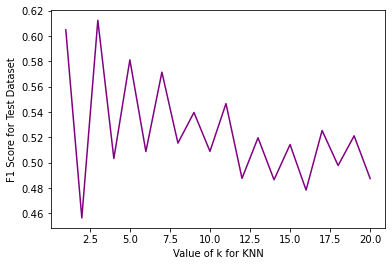

In [78]:
#plot the relationship between testing accuracy and F1-scores across a range of k values
plt.plot(k_range, test_scores_f1, color='purple')
plt.xlabel("Value of k for KNN")
plt.ylabel("F1 Score for Test Dataset")
plt.show()

In [79]:
#k=3 gives us the best result based on the code below
#make sure this code is here so that we always choose the optimal # of neighbors to run in our KNN model
MaxF1Test=max(test_scores_f1)
print(MaxF1Test)
BestK=test_scores_f1.index(MaxF1Test)+1
BestK

0.6124031007751939


3

In [80]:
#KNN model with the best k value

f1score_train = []
f1score_test = []
avg_f1score_train = []
avg_f1score_test = []

for i in range(10):
  knn = KNeighborsClassifier(n_neighbors=BestK)
  X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
  knn.fit(X_train_scaled, y_train)
  y_pred_train = knn.predict(X_train_scaled)
  y_pred_test = knn.predict(X_test_scaled)
  f1score_train.append(f1_score(y_train, y_pred_train, zero_division=1))
  f1score_test.append(f1_score(y_test, y_pred_test, zero_division=1))

f1_knn_train=((np.mean(f1score_train))).round(3) #F1-score at k=3
print(f1_knn_train)
f1_knn_test=((np.mean(f1score_test))).round(3) #F1-score at k=3
print(f1_knn_test)

0.779
0.667


The KNN model has an F1-score of 0.667 for the testing dataset.

## Gaussian Naive Bayes Model

In [91]:
#Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_test = gaussian.predict(X_test)
y_pred_train = gaussian.predict(X_train)
#accuracy_gaussian = (accuracy_score(y_test,y_pred)*100).round(2)
f1_gaussian_train = (f1_score(y_train, y_pred_train, zero_division=1)).round(3)
f1_gaussian_test = (f1_score(y_test, y_pred_test, zero_division=1)).round(3)
#print(accuracy_gaussian)
print(f1_gaussian_test)
print(f1_gaussian_train)

0.66
0.66


In [92]:
#since Gaussian Naive Bayes model makes the assumption that the predictors are independent (i.e. features are not correlated to each other) 
#highly correlated attributes are counted twice in the model which can lead to over-estimating the importance of those attributes and thus the performance of the classifier degrades
#the model was re-run using the lower multicollinearity dataset 'bank_model_2' 
gaussian_2 = GaussianNB()
gaussian_2.fit(X_train_2, y_train_2)
y_pred_test_2 = gaussian_2.predict(X_test_2)
y_pred_train_2 = gaussian_2.predict(X_train_2)
#accuracy_gaussian = (accuracy_score(y_test,y_pred)*100).round(2)
f1_gaussian_train_2 = (f1_score(y_train_2, y_pred_train_2, zero_division=1)).round(3)
f1_gaussian_test_2 = (f1_score(y_test_2, y_pred_test_2, zero_division=1)).round(3)
#print(accuracy_gaussian)
print(f1_gaussian_test_2)
print(f1_gaussian_train_2)

0.48
0.468


In this case the Naive Bayes model worked best even when there was non-independence in the attributes. As such, the benefit of removing attributes to lower multicollinearity in the dataset did not outweight the information brought by those features to the model. Overall, the Naive Bayes model has an F1-score of 0.66 for the testing dataset.

## Decision Tree Classification Model

In [93]:
#Decision Tree Classification
decision_tree = DecisionTreeClassifier(max_depth = 3) #create Decision Tree classifier object
decision_tree.fit(X_train, y_train)
#tree.plot_tree(decision_tree)
y_pred_test = decision_tree.predict(X_test) #predict the response for test dataset
y_pred_train = decision_tree.predict(X_train)

f1_decision_tree_train = (f1_score(y_train, y_pred_train, zero_division=1)).round(3)
f1_decision_tree_test = (f1_score(y_test, y_pred_test, zero_division=1)).round(3)

print(f1_decision_tree_train)
print(f1_decision_tree_test)

0.725
0.683


The Decision Tree Classifier had an F1-score of 0.683 for the testing dataset.

## Random Forest Model

Acknowledging the overfitting risk, we want to choose the optimal depth before running the Random Forest model. As the result below shows, the F1-score for training dataset reaches 1 within a normal depth range, indicating our dataset contains enough information for Random Forest to learn and make a good prediction, instead of over-running on depth and overfitting. Thus, we only need to choose the depth which gives us the best F1-score on the training set. 

In [81]:
# Choose the best max_depth to Run Random Forest Classification Model(criteria importance: F1-score over overfitting)
# max_depth usually between 5-15
# Training
MaxDepth=pd.DataFrame(columns=["max_depth","F1_train","F1_test","F1_Delta"])
for n in range(1,25):
    rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=None,max_depth=n)
    rf_clf.fit(X_train, y_train)
    # Testing
    y_pred_test = rf_clf.predict(X_test) #make predictions for the test set
    y_pred_train = rf_clf.predict(X_train)
    # F1-score
    f1_rf_clf_train=(f1_score(y_train, y_pred_train)).round(3)
    f1_rf_clf_test=(f1_score(y_test, y_pred_test)).round(3)
    f1_rf_clf_delta=f1_rf_clf_train-f1_rf_clf_test
    MaxDepth=MaxDepth.append({'max_depth':n,'F1_train':f1_rf_clf_train,'F1_test':f1_rf_clf_test,'F1_Delta':f1_rf_clf_delta},ignore_index=True)
print(MaxDepth)

    max_depth  F1_train  F1_test  F1_Delta
0         1.0     0.000    0.000     0.000
1         2.0     0.208    0.204     0.004
2         3.0     0.507    0.475     0.032
3         4.0     0.657    0.625     0.032
4         5.0     0.701    0.647     0.054
5         6.0     0.770    0.705     0.065
6         7.0     0.838    0.754     0.084
7         8.0     0.879    0.797     0.082
8         9.0     0.916    0.818     0.098
9        10.0     0.947    0.832     0.115
10       11.0     0.969    0.858     0.111
11       12.0     0.982    0.865     0.117
12       13.0     0.987    0.868     0.119
13       14.0     0.994    0.872     0.122
14       15.0     0.996    0.868     0.128
15       16.0     0.999    0.870     0.129
16       17.0     1.000    0.881     0.119
17       18.0     1.000    0.861     0.139
18       19.0     1.000    0.889     0.111
19       20.0     1.000    0.874     0.126
20       21.0     1.000    0.875     0.125
21       22.0     1.000    0.871     0.129
22       23

In [82]:
MaxF1Test=max(MaxDepth['F1_test'])
print(MaxF1Test)
BestMaxDepth=(MaxDepth.loc[MaxDepth['F1_test']==MaxF1Test,['max_depth']]['max_depth']).values[0]
BestMaxDepth

0.889


19.0

In [83]:
  f1ScoreList_train= []
  f1ScoreList_test= []
for i in range (10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify = y)
    # Training
    rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=None,max_depth=BestMaxDepth)
    rf_clf.fit(X_train, y_train)
    # Testing
    y_pred_test = rf_clf.predict(X_test) #make predictions for the test set
    y_pred_train = rf_clf.predict(X_train) #make predictions for the test set
    # F1-Score
    f1Score_train=f1_score(y_train, y_pred_train, zero_division=1)
    f1Score_test=f1_score(y_test, y_pred_test, zero_division=1)
    f1ScoreList_train.append(f1Score_train)
    f1ScoreList_test.append(f1Score_test)
f1_rf_clf_train=((np.mean(f1ScoreList_train))).round(3)
f1_rf_clf_test=((np.mean(f1ScoreList_test))).round(3)

print(f1_rf_clf_train)
print(f1_rf_clf_test)

1.0
0.872


The Random Forest model has an F1-score of 0.872 for the testing dataset.

### Feature Importance
Since Random Forest performed very well, we decided to dig further into the model output. Starting with Feature Importance, we noticed that a customer's past year usage behavior contributed the most for satisfying prediction, especially total transaction count and amount in past 12 months, and change in transaction count (Q4 over Q1). 

However , we cannot conclude that card category, education level, marital status or gender feature are not important as Random Forest tends to put more attention on the features which have more unique values. The nature of dummy variables will typically find themselves towards the bottom of the list.  

In [86]:
# Feature Importance
#measure the relative importance of each attribute
df_imp = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, columns=["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_imp

,Feature Importance
Total_Trans_Amt_12month,0.185170
Total_Trans_Count_12month,0.169439
Count_Chng_Q4_Q1,0.118889
CreditCard_Revolving_Balance,0.103506
Product_Count,0.068290
Avg_Utilization_Ratio,0.066661
Amt_Chng_Q4_Q1,0.062228
CreditCard_Limit,0.038508
Customer_Age,0.036886
Contacts_Count_12month,0.029968


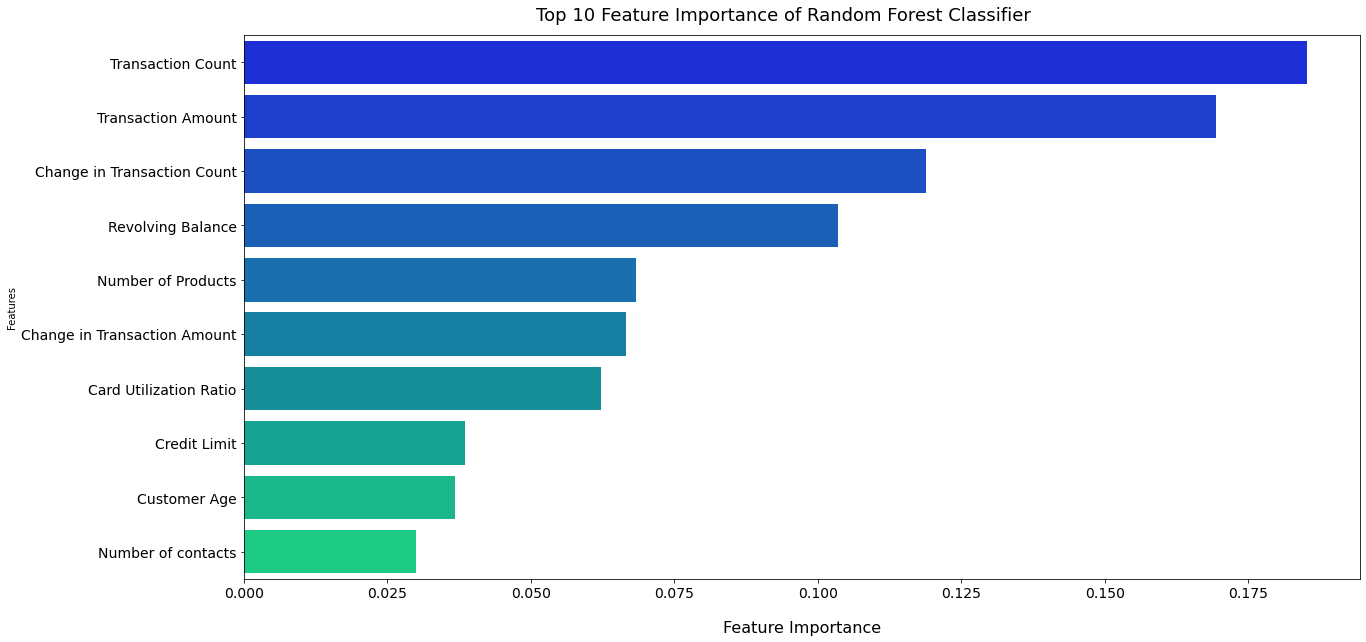

In [87]:
# Top 10 features importance plot
df_imp_top_10=df_imp.nlargest(10,'Feature Importance')
df_imp_top_10['Features']=["Transaction Count","Transaction Amount","Change in Transaction Count",
                      "Revolving Balance","Number of Products","Change in Transaction Amount",
                      "Card Utilization Ratio","Credit Limit","Customer Age","Number of contacts"]
fig = plt.figure(figsize=(20,10))
plt.xlabel('Feature Importance', size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
ax = sns.barplot(x=df_imp_top_10['Feature Importance'], y=df_imp_top_10['Features'], data=df_imp, palette="winter")
fig.suptitle("Top 10 Feature Importance of Random Forest Classifier", y=0.92, fontsize=18);

Moreover, we are able to generate insights on how those important features help the bank identify what types of customers are leaving: 


1.   Customers who have only 1 or 2 products and have less than 45 transactions in the past year
2.   Customers whose credit card limit is less than 3398 and have less than 42 transactions in the past year
3. Customers who hold a Platinum credit card and have less than 5000 transaction amounts in the past year




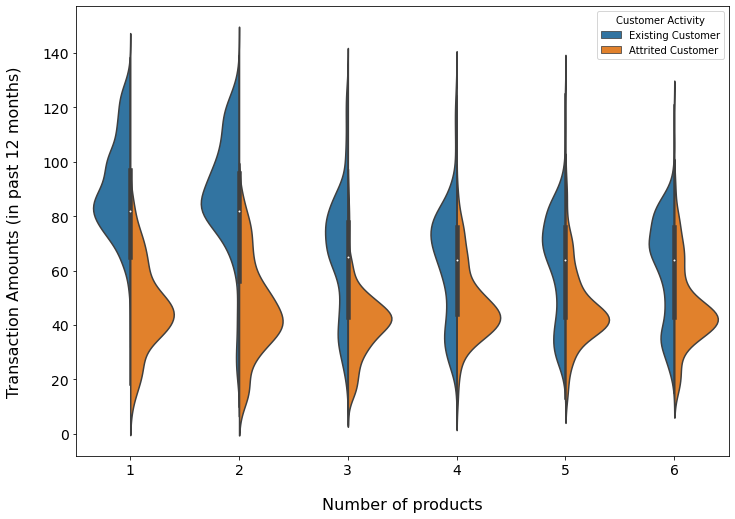

In [88]:
# Violinplot
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
V1 = sns.violinplot(x="Product_Count",y="Total_Trans_Count_12month",hue="Attrition_Flag",data=bank,split=True)
plt.ylabel("Transaction Amounts (in past 12 months)", size=16, labelpad=20)
plt.xlabel("Number of products", size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(title = "Customer Activity"); 

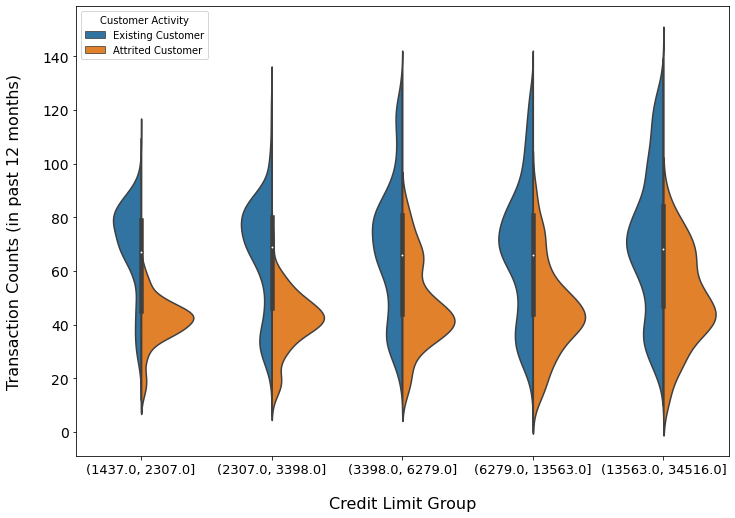

In [89]:
fig, ax = plt.subplots(figsize=a4_dims)
V2 = sns.violinplot(x="CreditCard_Limit_Group",y="Total_Trans_Count_12month",hue="Attrition_Flag",data=bank,split=True)
plt.ylabel("Transaction Counts (in past 12 months)", size=16, labelpad=20)
plt.xlabel("Credit Limit Group", size=16, labelpad=20)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=14)
plt.legend(title = "Customer Activity"); 

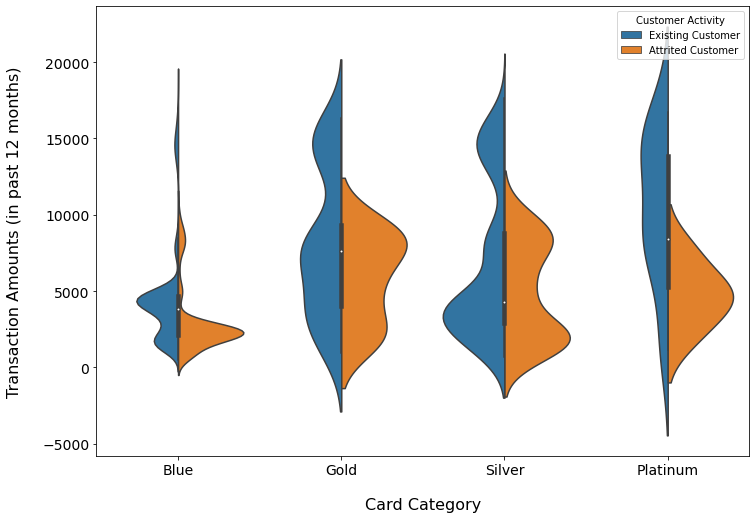

In [90]:
fig, ax = plt.subplots(figsize=a4_dims)
V3 = sns.violinplot(x="Card_Category",y="Total_Trans_Amt_12month",hue="Attrition_Flag",data=bank,split=True)
plt.ylabel("Transaction Amounts (in past 12 months)", size=16, labelpad=20),
plt.xlabel("Card Category", size=16, labelpad=20),
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(title = "Customer Activity"); 

# Which is the best model?

In [94]:
#Create a dataframe of the accuracy scores of each of the models
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'Gaussian Naive Bayes', 'Decision Tree'],
    #'AccuracyScore': [accuracy_log_reg, accuracy_knn, accuracy_rf_clf, accuracy_gaussian, accuracy_decision_tree],
    'F1Score-Train': [f1_log_reg_train, f1_knn_train, f1_rf_clf_train, f1_gaussian_train, f1_decision_tree_train],
    'F1Score-Test': [f1_log_reg_test, f1_knn_test, f1_rf_clf_test, f1_gaussian_test, f1_decision_tree_test]})
model_results = models.sort_values(by='F1Score-Test', ascending=False)
model_results = model_results.set_index('Model')
model_results

,F1Score-Train,F1Score-Test
Model,,
Random Forest,1.000,0.872
Decision Tree,0.725,0.683
KNN,0.779,0.667
Logistic Regression,0.664,0.661
Gaussian Naive Bayes,0.660,0.660




> From an accuracy perspective, the Random Forest model provides the highest F1-score on test set, followed by Decision Tree, KNN, Logistic Regression, and Naive Bayes.



> Regarding the risk of overfitting, as state above, the F1-score of Random Forest train set reached a maximum within a normal depth range, suggesting our dataset contained adequate information for prediction instead of model overfitting.


> Thus, the Random Forest model is the best model for predicting credit card customer churn. 